In [1]:
# This is to see whether the GPU is being used. Sometimes, it might be that the GPU is not available due to high demand. 
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install -U imbalanced-learn

    100% |████████████████████████████████| 153kB 13.6MB/s 
Requirement not upgraded as not directly required: scipy in /usr/local/lib/python3.6/dist-packages (from imbalanced-learn) (0.19.1)
Requirement not upgraded as not directly required: numpy in /usr/local/lib/python3.6/dist-packages (from imbalanced-learn) (1.14.5)
Requirement not upgraded as not directly required: scikit-learn in /usr/local/lib/python3.6/dist-packages (from imbalanced-learn) (0.19.1)


In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

In [0]:
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

In [0]:
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [11]:
!mkdir gdrive
!google-drive-ocamlfuse gdrive
!ls gdrive

Colab  Colab Notebooks


In [0]:
import os
os.chdir('gdrive')
os.chdir('Colab Notebooks')

In [13]:
!ls

data_loader.py				     gdrive
datasets				     images
Deep Learning Paper No Oversampling.ipynb    match_train.npy
Deep Learning Paper Oversampling.ipynb	     __pycache__
Deep Learning Paper Undersampling.ipynb      spoken_train.npy
DLwithKeras6_colab.4.epoch.PET.to.MRI.ipynb  written_train.npy
DLwithKeras6.ipynb


In [14]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from __future__ import print_function

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import Adam, Nadam
from keras.constraints import max_norm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

Using TensorFlow backend.


In [0]:
spoken_train = np.load('spoken_train.npy')
written_train = np.load('written_train.npy')
match_train = np.load('match_train.npy')

In [16]:
spoken_train.shape
written_train.shape
print(len(match_train[match_train == False]))
print(spoken_train[0].shape)

40646
(32, 13)


In [0]:
def reshape_spoken(spoken):
    spoken_padded = []
    for example in spoken:
        empty = np.zeros((112-example.shape[0], 13))
        
        # pad spoken data with zeros to create uniform shape
        example_p = np.vstack([example, empty])
        
        # reshape to one dimensional array, so it can be handled by StandardScaler
        example_p = example_p.reshape(1456,)
        spoken_padded.append(example_p)
    return np.array(spoken_padded)

spoken_train_re = reshape_spoken(spoken_train)
#spoken_test_re = reshape_spoken(spoken_test)

In [18]:
# First we create a separate test set and training set


X_w, X_w_test, X_s, X_s_test, y_train, y_test = train_test_split(written_train, spoken_train_re, match_train, test_size=0.1, random_state=42)

# scale written data
scaler = StandardScaler()
X_w_scaled = scaler.fit_transform(X_w)
X_w_test_scaled = scaler.transform(X_w_test)
#written_test_scaled = scaler.transform(written_test)

# scale spoken data seperately
scaler_s = StandardScaler()
X_s_scaled = scaler_s.fit_transform(X_s)
X_s_test_scaled = scaler_s.transform(X_s_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [19]:
def combine_data_2D(written, spoken):
    combined_examples = []
    for i in range(len(spoken)):
        result = np.hstack([written[i,:], spoken[i]])
        combined_examples.append(result)
    return np.array(combined_examples)

X_train_2D = combine_data_2D(X_w_scaled, X_s_scaled)
X_test_2D = combine_data_2D(X_w_test_scaled, X_s_test_scaled)

print(X_train_2D.shape)
print(X_test_2D.shape)

(40500, 2240)
(4500, 2240)


In [20]:
print(y_train.shape)

(40500,)


In [21]:
# Now we need to split the training data in validation and actual training data

x_train, x_val, y_train, y_val = train_test_split(X_train_2D, y_train, test_size=0.2, 
                                                                 random_state=42)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)




(32400, 2240)
(8100, 2240)
(32400,)
(8100,)


In [0]:
# If you want to apply oversampling or undersampling you have to do it from here

sm = SMOTE()

x_resampled, y_resampled = sm.fit_sample(x_train, y_train)


In [23]:
print(x_resampled.shape)
print(y_resampled.shape)

(58482, 2240)
(58482,)


In [24]:
def combine_data_3D(data_2D):
    written = data_2D[:, :784]
    spoken = data_2D[:, 784:]
    combined_examples = []
    for i in range(len(spoken)):
        # reshape written data to it's natural 28 by 28 shape
        written_28x28 = written[i].reshape(28, 28)
        
        # first reshape spoken data back from 1 dimensional
        # to 112 by 13 (= number of examples by number of MFCC features)
        spoken_re = spoken[i].reshape((112, 13))
        
        # then reshape into 4 side by side columns of 28 rows, 
        # which can be combined with written data
        
        # in this version we're adding extra padding with zero's 
        # which might reduce noise by seperating written and spoken data 
        # whose spatial nearness is not informative
        # Padding width should be at least the width of the kernel of the first Conv2D layer.
        pad = np.zeros((28, 5))
        spoken_stack = [pad, spoken_re[:28,:], pad, spoken_re[28:56,:], pad, spoken_re[56:84,:], pad, spoken_re[84:112,:]]
        spoken_28x72 = np.hstack(spoken_stack)
        
        # combine written and spoken data to one 2D array (28 by 80)
        result = np.hstack([written_28x28, spoken_28x72])
        combined_examples.append(result)
    return np.array(combined_examples)

X_train = combine_data_3D(x_resampled)
X_val = combine_data_3D(x_val)
X_test = combine_data_3D(X_test_2D)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(58482, 28, 100)
(8100, 28, 100)
(4500, 28, 100)


In [25]:
print(y_resampled.shape)
print(y_val.shape)
print(y_test.shape)

print()
print(len(y_resampled[y_resampled == 1]))
print(len(y_val[y_val == 1]))
print(len(y_test[y_test == 1]))

(58482,)
(8100,)
(4500,)

29241
757
438


In [26]:
# variables to use for training and validation are X_train, y_train and X_val, y_val

from sklearn.metrics import f1_score
batch_size = 128
#num_classes = 2
epochs = 100

# input image dimensions
img_rows, img_cols = 28, 100

# This code reshapes to the fomat that the back end, in my case Tensorflow, requires
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_val = X_val.reshape(X_val.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = y_resampled.astype(int)
y_val = y_val.astype(int)


model = Sequential()

model.add(Conv2D(30, (5, 5), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(15, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.7))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_constraint=max_norm(2.)))
model.add(Dense(50, activation='relu', kernel_constraint=max_norm(2.)))
model.add(Dense(25, activation='relu', kernel_constraint=max_norm(2.)))
model.add(Dense(10, activation='relu', kernel_constraint=max_norm(2.)))
model.add(Dense(1, activation='sigmoid'))
	# Compile model
    
optimizer = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


model.summary()


X_train shape: (58482, 28, 100, 1)
58482 train samples
8100 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 96, 30)        780       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 48, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 46, 15)        4065      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 23, 15)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 23, 15)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1725)              0         
_________________________________________________________________
den

In [0]:

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
         validation_data=(X_val, y_val))



Populating the interactive namespace from numpy and matplotlib


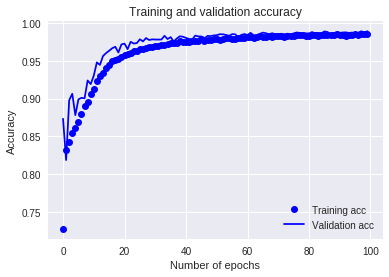

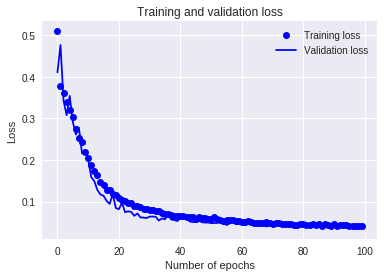

In [28]:
# plotting validation and training accuracy and loss
import matplotlib.pyplot as plt
%pylab inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [29]:
# Test set results for SMOTE oversampling
#After 100 epochs
y_pred = model.predict_classes(X_test)

y_pred_list = []
for i in range(len(y_pred)):
    y_pred_list.append(int(y_pred[i]))

print(accuracy_score(y_pred_list, y_test))
print("f1 score: {}".format(f1_score(y_pred_list, y_test)))
print(precision_score(y_pred_list, y_test))
print(recall_score(y_pred_list, y_test))

0.9902222222222222
f1 score: 0.95
0.954337899543379
0.9457013574660633


In [0]:
from keras.callbacks import Callback
import numpy as np
from sklearn.metrics import f1_score


class IoU(Callback):
    def __init__(self, x, y_true, num_classes):
        super().__init__()

        self.x = x
        self.y_true = y_true
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):    
        target_list = []
        pred_list = []
        for idx in range(len(self.x)):
            # Get a training sample and make a prediction using the current model
            sample = self.x[[idx]]
            target = self.y_true[[idx]]
            
            predicted = self.model.predict_classes(sample)
            target_list.append(int(target))
            pred_list.append(int(predicted[np.array([0])]))
            
                
        
        target_list = np.asarray(target_list)
        pred_list = np.asarray(pred_list)
        f1 = f1_score(target_list, pred_list)
        

        print("f1_score: {}\n".format(f1))

In [79]:
f1_callback = IoU(X_train, y_train, 2)

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1, validation_data=(X_val, y_val),
                    callbacks=[f1_callback])

Train on 58482 samples, validate on 8100 samples
Epoch 1/5
58482/58482 [==============================] - 11s 182us/step - loss: 0.4507 - acc: 0.7731 - val_loss: 0.4795 - val_acc: 0.8041
f1_score: 0.8557291396342624

Epoch 2/5
58482/58482 [==============================] - 11s 180us/step - loss: 0.2976 - acc: 0.8730 - val_loss: 0.3929 - val_acc: 0.8417
f1_score: 0.9030295861987395

Epoch 3/5
17408/58482 [=======>......................] - ETA: 7s - loss: 0.2275 - acc: 0.9045

58482/58482 [==============================] - 10s 179us/step - loss: 0.2070 - acc: 0.9140 - val_loss: 0.3203 - val_acc: 0.8656
f1_score: 0.9326307363927429

Epoch 4/5
58482/58482 [==============================] - 11s 180us/step - loss: 0.1334 - acc: 0.9461 - val_loss: 0.2043 - val_acc: 0.9189
f1_score: 0.9658303545714818

Epoch 5/5
42496/58482 [====================>.........] - ETA: 2s - loss: 0.0923 - acc: 0.9647

58482/58482 [==============================] - 11s 180us/step - loss: 0.0910 - acc: 0.9656 - val_loss: 0.1702 - val_acc: 0.9398
f1_score: 0.9780680646270197



In [80]:
y_pred = model.predict_classes(X_val)

y_pred_list = []
for i in range(len(y_pred)):
    y_pred_list.append(int(y_pred[i]))

print(accuracy_score(y_pred_list, y_val))
print("f1 score: {}".format(f1_score(y_pred_list, y_val)))
print(precision_score(y_pred_list, y_val))
print(recall_score(y_pred_list, y_val))

0.9397530864197531
f1 score: 0.6666666666666667
0.6446499339498019
0.6902404526166902
